# PINN

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE import lhs
from scipy.interpolate import griddata
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class PINN(nn.Module):
    def __init__(self, x_u, u, x_f, nu, lb, ub, layers):
        super(PINN, self).__init__()
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        self.x_u = torch.tensor(x_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(x_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(x_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(x_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.nu = nu
        self.layers = layers

        self.fc = self.initialize_nn(layers)

        self.to(device)

    def initialize_nn(self, layers):
        modules = []
        for i in range(1, len(layers) - 1):
            modules.append(nn.Linear(layers[i-1], layers[i]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*modules)
    
    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        u = self.fc(X)
        return u
    
    def pde_loss(self, x, t):
        u = self.forward(x, t)
        u_x = torch.autograd.grad(u, x, 
                                  grad_outputs=torch.ones_like(u), 
                                  retain_graph=True,
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, 
                                   grad_outputs=torch.ones_like(u_x), 
                                   retain_graph=True,
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, 
                                  grad_outputs=torch.ones_like(u), 
                                  retain_graph=True,
                                  create_graph=True)[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def initial_condition_loss(self):
        u0_pred = self.forward(self.x_f, torch.zeros_like(self.x_f))
        u0_true = torch.tensor(self.predict(self.x_f, self.t_f), requires_grad=True).to(device)
        return torch.mean((u0_pred - u0_true)**2)
    
    def train(self, nIter):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(nIter):
            optimizer.zero_grad()
            pde_loss = self.pde_loss(self.x_u, self.t_u)
            pde_loss = torch.mean(pde_loss**2)
            ic_loss = self.initial_condition_loss()
            loss = pde_loss + ic_loss
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0 and epoch > 0:
                print(f'Epoch {epoch}, Loss {loss}')

    def predict(self, x, t):
        x = torch.tensor(x).clone().detach().requires_grad_(True).float().to(device)
        t = torch.tensor(t).clone().detach().requires_grad_(True).float().to(device)
        return self.forward(x, t).detach().cpu().numpy()

In [39]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [44]:
model = PINN(X_u_train, u_train, X_f_train, nu, lb, ub, layers)

nIter = 10000
model.train(nIter)

<ipython-input-43-035ddc22f5ad>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).clone().detach().requires_grad_(True).float().to(device)
<ipython-input-43-035ddc22f5ad>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).clone().detach().requires_grad_(True).float().to(device)


Epoch 1000, Loss 4.1970341868591277e-08
Epoch 2000, Loss 1.3630044870538427e-09
Epoch 3000, Loss 3.3095071128030895e-10
Epoch 4000, Loss 6.871006541508962e-11
Epoch 5000, Loss 3.8943237523625385e-11
Epoch 6000, Loss 2.5538744730102536e-11
Epoch 7000, Loss 1.610337731217104e-11
Epoch 8000, Loss 1.1431837247666277e-11
Epoch 9000, Loss 7.990936905233337e-12


In [45]:
u_pred = model.predict(X_star[:, 0:1], X_star[:, 1:2])

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 3.899927e+00


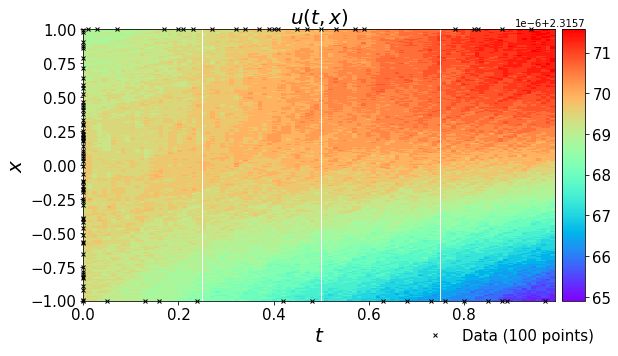

In [46]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

<ipython-input-47-9f8e96082c41>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])


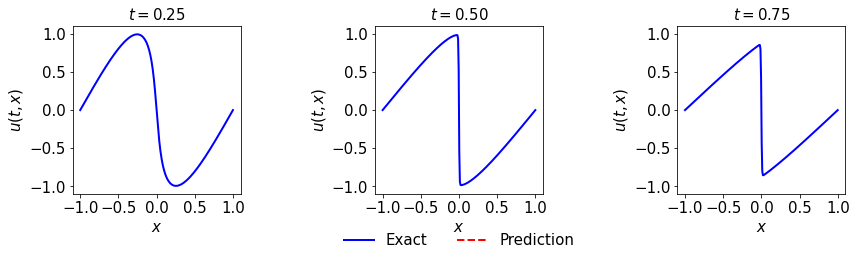

In [47]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

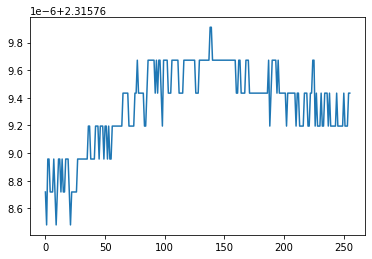

In [50]:
plt.plot(U_pred[18])